In [1]:
import torch 
from torch.utils.data import Dataset,Subset, DataLoader
import torchvision
import os
from PIL import Image, ImageFile
from torchvision import transforms, datasets
from pathlib import Path
# split validation set into new train and validation set
from sklearn.model_selection import train_test_split
#plot examples
import matplotlib.pyplot as plt
import numpy as np
from tqdm import tqdm
import torch.nn as nn
torch.manual_seed(42)
np.random.seed(42)

from baselineCNN import *

ImageFile.LOAD_TRUNCATED_IMAGES = True

In [2]:
dataset_path = Path('./../wildfire-prediction-dataset')

In [3]:
pretrain_path = dataset_path / 'train'
val_path = dataset_path / 'valid'
test_path = dataset_path / 'test'

In [4]:
dataset = datasets.ImageFolder(test_path, transform=transforms.ToTensor())

torch.Size([3, 350, 350])


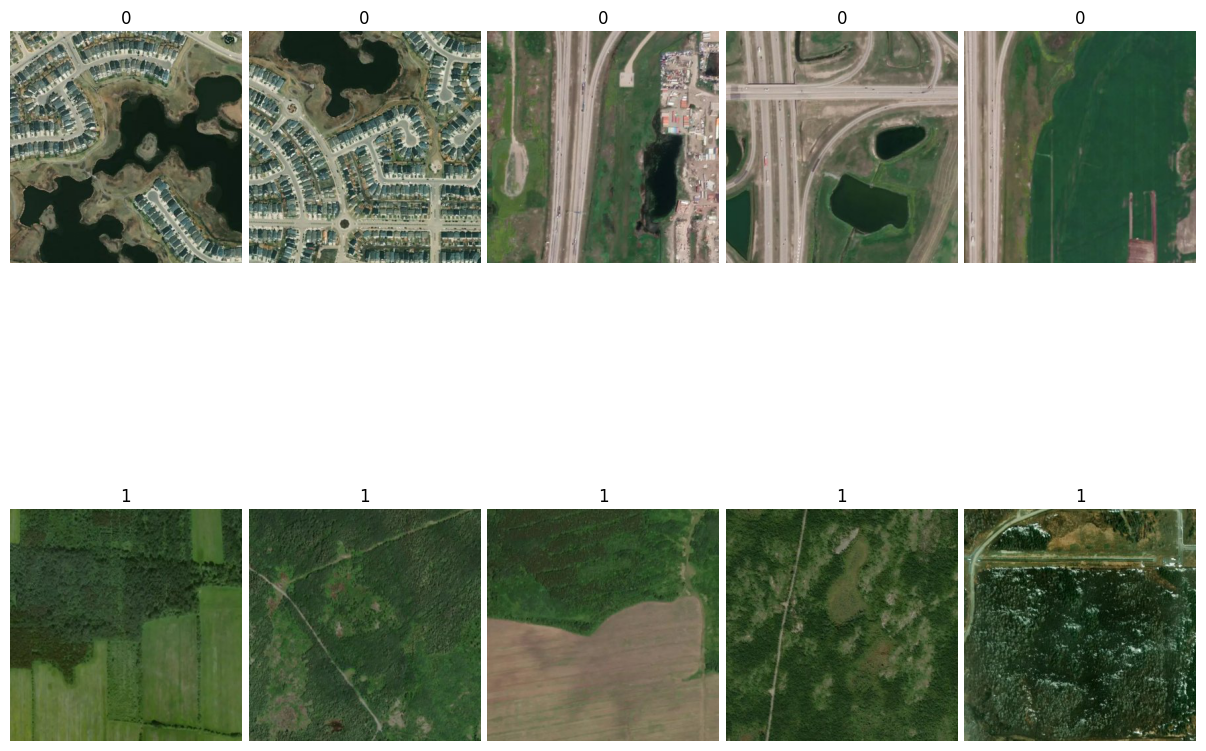

In [5]:


fig, axes = plt.subplots(2, 5, figsize=(12, 12))
#print size of an image

print(dataset[0][0].shape)

for idx in range(5):
    image, label = dataset[idx]
    ax = axes[0, idx]  # First row
    ax.imshow(image.permute(1, 2, 0))
    ax.set_title(label)
    ax.axis('off')
    
for idx in range(1,6):
    image, label = dataset[-idx]
    ax = axes[1, idx-1]  # Second row
    ax.imshow(image.permute(1, 2, 0))
    ax.set_title(label)
    ax.axis('off')
plt.tight_layout(pad=0.5)
plt.show()




In [6]:
def get_all_datasets(pretrain_path, val_path, test_path, transforms):
    
    pretrain_dataset = datasets.ImageFolder(pretrain_path, transform=transforms['pretrain'])
    val_dataset = datasets.ImageFolder(val_path, transform=transforms['valid'])
    test_dataset = datasets.ImageFolder(test_path, transform=transforms['test'])
    train_idx, validation_idx = train_test_split(np.arange(len(val_dataset)),
                                             test_size=0.2,
                                             random_state=42,
                                             shuffle=True,
                                             stratify=val_dataset.targets)
    train_dataset = Subset(val_dataset, train_idx)
    val_dataset = Subset(val_dataset, validation_idx)
    
    return pretrain_dataset, train_dataset, val_dataset, test_dataset

In [7]:
num_epochs = 10
batch_size = 64     

In [8]:

# Data transformations
data_transforms = {
    'pretrain': transforms.Compose([
        transforms.ToTensor(),
    ]),
    'valid': transforms.Compose([
        transforms.ToTensor(),
    ]),
    'test': transforms.Compose([
        transforms.ToTensor(),
    ]),
}
_, train_dataset, val_dataset, test_dataset = get_all_datasets(pretrain_path, val_path, test_path, data_transforms)

train_data_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True, num_workers=6)
val_data_loader = DataLoader(val_dataset, batch_size=batch_size, shuffle=False, num_workers=6)
test_data_loader = DataLoader(test_dataset, batch_size=batch_size, shuffle=False, num_workers=6)


In [9]:
model = BaselineModel()

In [ ]:

optimizer = torch.optim.Adam(model.parameters(), lr=1e-4)
criterion = nn.CrossEntropyLoss()
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model = model.to(device)


In [11]:
def train_one_epoch(model, optimizer, data_loader, loss_fn, device):
    model.train()
    losses = []
    for x, y in tqdm(data_loader):
        x = x.to(device).half()  # Convert to float16
        y = y.to(device)
        optimizer.zero_grad()
        with torch.amp.autocast('cuda'):  # Use automatic mixed precision
            y_hat = model(x)
            loss = loss_fn(y_hat, y)
        loss.backward()
        optimizer.step()
        losses.append(loss.item())
    return losses

def validate(model, data_loader, loss_fn, device):
    model.eval()
    losses = []
    correct_predictions = 0
    with torch.no_grad():
        for x, y in tqdm(data_loader):
            x = x.to(device).half()  # Convert to float16
            y = y.to(device)
            with torch.amp.autocast('cuda'):
                y_hat = model(x)
                loss = loss_fn(y_hat, y)
            losses.append(loss.item())
            correct_predictions += (y == y_hat.argmax(1)).sum().item()
    return losses, correct_predictions


Epoch 1/10


  0%|          | 0/79 [00:00<?, ?it/s]

100%|██████████| 20/20 [00:03<00:00,  5.12it/s]


Train Loss: 0.9566 Validation Loss: 0.6354 Validation Accuracy: 0.7833
Epoch 2/10


100%|██████████| 20/20 [00:03<00:00,  6.16it/s]


Train Loss: 0.2224 Validation Loss: 0.3854 Validation Accuracy: 0.8032
Epoch 3/10


100%|██████████| 20/20 [00:03<00:00,  5.81it/s]


Train Loss: 0.3389 Validation Loss: 0.3064 Validation Accuracy: 0.8532
Epoch 4/10


100%|██████████| 20/20 [00:03<00:00,  5.93it/s]


Train Loss: 0.1682 Validation Loss: 0.1949 Validation Accuracy: 0.9246
Epoch 5/10


100%|██████████| 20/20 [00:03<00:00,  5.52it/s]


Train Loss: 0.2245 Validation Loss: 0.2037 Validation Accuracy: 0.9198
Epoch 6/10


100%|██████████| 20/20 [00:03<00:00,  5.36it/s]


Train Loss: 0.0833 Validation Loss: 0.1816 Validation Accuracy: 0.9405
Epoch 7/10


100%|██████████| 20/20 [00:03<00:00,  5.34it/s]


Train Loss: 0.0575 Validation Loss: 0.2027 Validation Accuracy: 0.9381
Epoch 8/10


100%|██████████| 20/20 [00:03<00:00,  5.42it/s]


Train Loss: 0.1027 Validation Loss: 0.2133 Validation Accuracy: 0.9190
Epoch 9/10


100%|██████████| 20/20 [00:03<00:00,  6.21it/s]


Train Loss: 0.0565 Validation Loss: 0.2426 Validation Accuracy: 0.9024
Epoch 10/10


100%|██████████| 20/20 [00:03<00:00,  5.44it/s]
/tmp/ipykernel_130382/3951863405.py:28: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  checkpoint = torch.load(best_model_path

Train Loss: 0.0410 Validation Loss: 0.2368 Validation Accuracy: 0.9079
Loaded best model from epoch 6 with validation accuracy: 0.9405


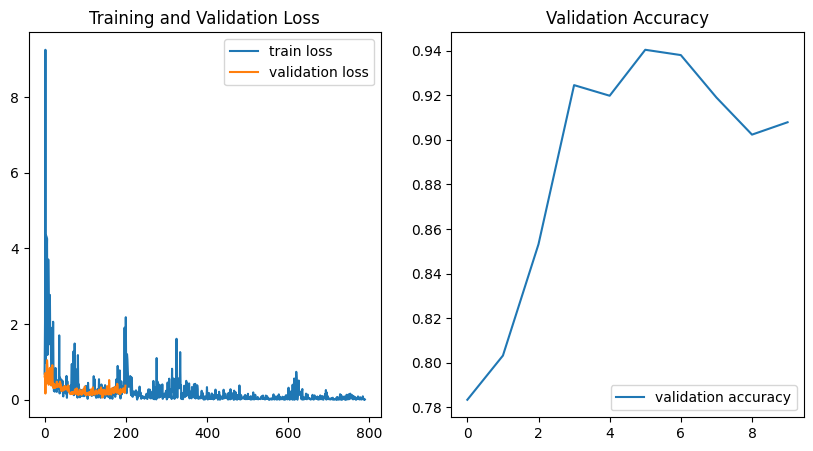

In [12]:
#train
train_losses = []
val_losses = []
val_accuracies = []
best_val_accuracy = 0
best_model_path = 'baseline.pth'

for epoch in range(num_epochs):
    print(f'Epoch {epoch + 1}/{num_epochs}')
    train_loss = train_one_epoch(model, optimizer, train_data_loader, criterion, device)
    val_loss, correct_predictions = validate(model, val_data_loader, criterion, device)
    val_accuracy = correct_predictions / len(val_dataset)
    train_losses.extend(train_loss)
    val_losses.extend(val_loss)
    val_accuracies.append(val_accuracy)
    
    if val_accuracy > best_val_accuracy:
        best_val_accuracy = val_accuracy
        torch.save({
            'epoch': epoch,
            'model_state_dict': model.state_dict(),
            'optimizer_state_dict': optimizer.state_dict(),
            'val_accuracy': val_accuracy,
        }, best_model_path)
    
    print(f'Train Loss: {np.mean(train_loss):.4f} Validation Loss: {np.mean(val_loss):.4f} Validation Accuracy: {val_accuracy:.4f}')

checkpoint = torch.load(best_model_path)
model.load_state_dict(checkpoint['model_state_dict'])
print(f"Loaded best model from epoch {checkpoint['epoch']+1} with validation accuracy: {checkpoint['val_accuracy']:.4f}")

# Plot training curves
plt.figure(figsize=(10, 5))
plt.subplot(1, 2, 1)
plt.plot(train_losses, label='train loss')
plt.plot(val_losses, label='validation loss')
plt.title('Training and Validation Loss')
plt.legend()

plt.subplot(1, 2, 2)
plt.plot(val_accuracies, label='validation accuracy')
plt.title('Validation Accuracy')
plt.legend()
plt.show()


In [ ]:
# Test the model
model.eval()
test_loss, correct_predictions = validate(model, test_data_loader, criterion, device)
test_accuracy = correct_predictions / len(test_dataset)
print(f'Test Loss: {np.mean(test_loss):.4f} Test Accuracy: {test_accuracy:.4f}')



100%|██████████| 99/99 [00:13<00:00,  7.38it/s]

Test Loss: 0.1905 Test Accuracy: 0.9417
